In [668]:
import pandas as pd
import numpy as np
import skfda
import matplotlib.pyplot as plt

np.float_ = np.float64

In [669]:
path = "/Users/ww.jedrzej/Library/CloudStorage/OneDrive-Personal/UAM/IX rok/temperature_fda/"

In [670]:
loc_data_august_expand = pd.read_csv(path + "data/loc_data_august_expand.csv")
loc_data_august = pd.read_csv(path + "data/loc_data_august.csv").iloc[:,1:]
loc_data_december_expand = pd.read_csv(path + "data/loc_data_december_expand.csv")
loc_data_december = pd.read_csv(path + "data/loc_data_december.csv")
kod_stacja = pd.read_csv(path + 'data/kod_stacja.csv')
dataset_august = pd.read_csv(path + "data/dataset_august.csv")
dataset_december = pd.read_csv(path + "data/dataset_december.csv")

In [671]:
dataset_august_pila = dataset_august.iloc[:,[0, 3]]

In [672]:
data = pd.merge(loc_data_august, dataset_august_pila, on='date', how='left')

data = data.rename(columns={'temp': 'Y', 'temp_230': 'X'})


In [678]:
def transformation_of_data(temp_df, n):
    
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    
    start_date = min(temp_df['date'])
    
    temp_df['rep'] = (temp_df['date'] - start_date).dt.days + 1
    temp_df['hour'] = temp_df['date'].dt.hour
    temp_df = temp_df.groupby(['rep', 'hour']).agg({'Y': 'mean', 'X': 'mean'}).reset_index()
    group_counts = temp_df.groupby('rep').size()
    valid_groups = group_counts[group_counts == 24].index
    df_filtered = temp_df[temp_df['rep'].isin(valid_groups)].copy()
    df_filtered['idx'] = df_filtered.groupby('rep').cumcount() #+ 1
    temp = df_filtered.pivot(index = 'idx', columns='rep', values='Y')
    weather = df_filtered.pivot(index = 'idx', columns='rep', values='X')
    
    all_sets = {'weather': weather, 'temp': temp}
    train_sets = {'weather': weather.iloc[:, n:], 'temp': temp.iloc[:, n:]}
    test_sets = {'weather': weather.iloc[:, :n], 'temp': temp.iloc[:, :n]}
    return all_sets, train_sets, test_sets, start_date

def transformation_of_data_2(temp_df):
    
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    
    start_date = min(temp_df['date'])
    
    temp_df['rep'] = (temp_df['date'] - start_date).dt.days + 1
    temp_df['hour'] = temp_df['date'].dt.hour
    temp_df = temp_df.groupby(['rep', 'hour']).agg({'X': 'mean'}).reset_index()
    group_counts = temp_df.groupby('rep').size()
    valid_groups = group_counts[group_counts == 24].index
    df_filtered = temp_df[temp_df['rep'].isin(valid_groups)].copy()
    df_filtered['idx'] = df_filtered.groupby('rep').cumcount() #+ 1
    weather = df_filtered.pivot(index = 'idx', columns='rep', values='X')
    
    results = {'weather': weather}
    return results, start_date

In [674]:
def reconstruction_mid_term(train_set):
    t = np.linspace(0, 23, 24)
    fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0,23), n_basis=3, period=24)

    Y_train = skfda.FDataGrid(
        data_matrix=train_set['temp'].T,
        grid_points=t,
    ).to_basis(fourier_basis)
    X_train = skfda.FDataGrid(
        data_matrix=train_set['weather'].T,
        grid_points=t,
    ).to_basis(fourier_basis)
    
    linear_reg = skfda.ml.regression.LinearRegression(
    coef_basis=[fourier_basis])
    
    _ = linear_reg.fit(X_train, Y_train)

    return linear_reg

def performance_mid_term(test_set, fd_linear_reg):
    t = np.linspace(0, 23, 24)
    fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0,23), n_basis=3, period=24)
    X_test = skfda.FDataGrid(
        data_matrix=test_set['weather'].T,
        grid_points=t,
    ).to_basis(fourier_basis)
    Y_test = skfda.FDataGrid(
        data_matrix=test_set['temp'].T,
        grid_points=t,
    ).to_basis(fourier_basis)
    error = np.mean(np.abs(np.squeeze(fd_linear_reg.predict(X_test)(t)) - np.squeeze(Y_test(t))))
    return error

def evaluation_mid_term(all_sets, start_date):
    t = np.linspace(0, 23, 24)
    fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0,23), n_basis=3, period=24)

    Y_train = skfda.FDataGrid(
        data_matrix=all_sets['temp'].T,
        grid_points=t,
    ).to_basis(fourier_basis)
    X_train = skfda.FDataGrid(
        data_matrix=all_sets['weather'].T,
        grid_points=t,
    ).to_basis(fourier_basis)
    
    linear_reg = skfda.ml.regression.LinearRegression(
    coef_basis=[fourier_basis])
    
    _ = linear_reg.fit(X_train, Y_train)
    
    eval = np.squeeze(linear_reg.predict(X_train)(t)).T
    eval_Y_train = np.squeeze(Y_train(t)).T
    
    vector_recon = eval.flatten(order='F')
    vector_local = eval_Y_train.flatten(order='F')
    vector_weather = all_sets['weather'].to_numpy().flatten(order='F')
    dates = pd.date_range(start=start_date, periods=len(vector_recon), freq='h')
    
    return pd.DataFrame({'date': dates, 'temp_recon': vector_recon, 'temp_local': vector_local, 'temp_weather' : vector_weather})

def evaluation_mid_term_2(linear_reg, X):
    t = np.linspace(0, 23, 24)
    fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0,23), n_basis=3, period=24)
    
    results, start_date = transformation_of_data_2(X)
    
    X_fda = skfda.FDataGrid(
        data_matrix=results['weather'].T,
        grid_points=t,
    ).to_basis(fourier_basis)

    eval = np.squeeze(linear_reg.predict(X_fda)(t)).T
    
    vector_recon = eval.flatten(order='F')
    dates = pd.date_range(start=start_date, periods=len(vector_recon), freq='h')
    
    return pd.DataFrame({'date': dates, 'temp_recon': vector_recon})

In [675]:
locations = data['location'].unique()

all_sets = {}
train_sets = {}
test_sets = {}
start_date = {}

for loc in locations:
    temp_df = data[data['location'] == loc].copy()
    temp_df = temp_df.drop(columns='location')
    
    all_sets[loc], train_sets[loc], test_sets[loc], start_date[loc] = transformation_of_data(temp_df, n = 3)
    

In [676]:
locations = data['location'].unique()
locations = [loc for loc in locations if loc not in ['basement', 'field', 'forest']]

for loc in locations:
    fd_linear_reg = reconstruction_mid_term(train_sets[loc])
    score = performance_mid_term(test_sets[loc], fd_linear_reg)
    print(loc + ": " + str(score))

attic: 1.2138367125935723
garage: 1.0957612204441334
roof: 1.0981998154471189
shack: 0.7428866022276206
underground: 0.665518072025253
uninhabited_building: 0.6285149175444121


In [679]:
weather_data = data[data['location'] == 'attic'][['date', 'X']]
evaluation_mid_term_2(fd_linear_reg, weather_data)

,date,temp_recon
0,2021-08-02 01:00:00+00:00,18.375695
1,2021-08-02 02:00:00+00:00,18.085563
2,2021-08-02 03:00:00+00:00,17.804209
3,2021-08-02 04:00:00+00:00,17.550807
4,2021-08-02 05:00:00+00:00,17.342626
...,...,...
355,2021-08-16 20:00:00+00:00,20.706044
356,2021-08-16 21:00:00+00:00,20.350784
357,2021-08-16 22:00:00+00:00,19.952322
358,2021-08-16 23:00:00+00:00,19.537813


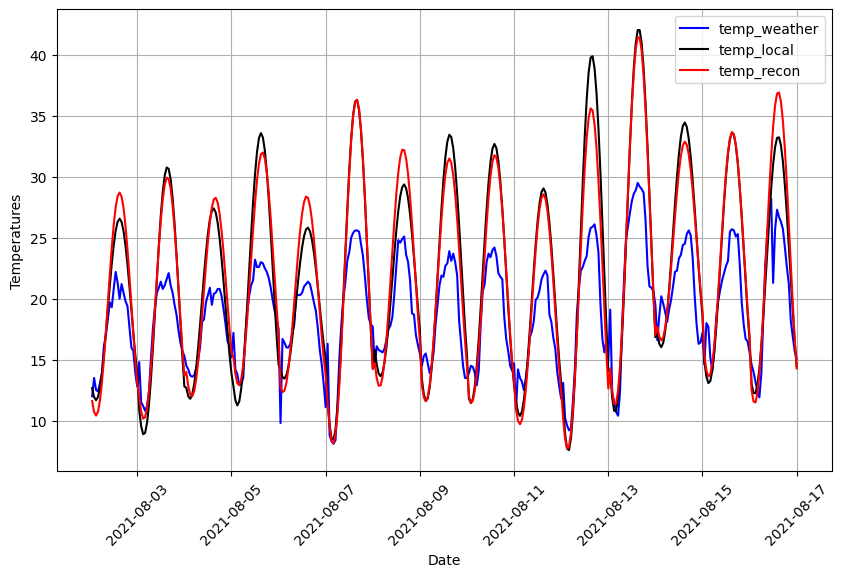

In [661]:
loc = 'roof'
results = evaluation_mid_term(all_sets[loc], start_date[loc])
plt.figure(figsize=(10, 6))

plt.plot(results['date'], results['temp_weather'], label='temp_weather', color = 'blue')
plt.plot(results['date'], results['temp_local'], label='temp_local', color = 'black')
plt.plot(results['date'], results['temp_recon'], label='temp_recon', color = 'red')

plt.xlabel('Date')
plt.ylabel('Temperatures')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.show()